# Projeto 02 – Classificação Automática  
## Introdução

**Unidade Curricular:** Inteligência Artificial  
**Projeto:** Project 02 – Data Mining / Machine Learning  
**Notebook:** Classificação automatica

Este notebook apresenta o desenvolvimento realizado pelo Grupo 3 composto por Tiago Sousa (20735), Rodrigo Castro (23143), Rogério Gomes (27216), Paulo Costa (29851) e Lais Carvalho (51067)  no âmbito do trabalho prático da disciplina de Inteligência Artificial.

O objetivo é construir modelos de **classificação automática** capazes de prever se um piloto **irá ou não marcar pontos** numa dada corrida de Fórmula 1, com base em informação conhecida **antes da corrida** (por exemplo: posição de partida, ano, equipa, etc.).

### Contexto e objetivo

No contexto da Fórmula 1, equipas e analistas procuram antecipar a probabilidade de um piloto terminar numa posição que lhe permita marcar pontos, uma vez que isso influencia:

- estratégias de corrida (paragens na box, pneus, ritmo de corrida);
- decisões de equipa (ordens de equipa, gestão de risco);
- análise de performance de pilotos e equipas ao longo das épocas.

Assim, a tarefa de classificação pode ser formulada como:

> **Dado um conjunto de características de uma corrida e de um piloto, prever se ele irá marcar pontos (1) ou não (0).**

Usaremos o dataset **Formula 1 World Championship (1950–2020)** (Kaggle), já utilizado nos restantes notebooks do projeto.


In [1]:
# 1. Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-v0_8')  # se der erro, trocar para 'seaborn'


## 2. Dados utilizados

Vamos utilizar os seguintes ficheiros do dataset de Fórmula 1:

- `results.csv` – resultados detalhados de cada piloto em cada corrida;
- `races.csv` – informação sobre cada corrida (ano, ronda, circuito, etc.);
- `drivers.csv` – informação básica dos pilotos;
- `constructors.csv` – informação das equipas (construtores).

### 2.1 Carregamento dos ficheiros


In [3]:
# Ajustar o caminho conforme a pasta onde os ficheiros foram extraídos (ex.: 'archive/results.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')

results.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### 2.2 Visão geral e critérios de seleção de dados

Nem todas as colunas disponíveis são necessárias para a tarefa de classificação.  
Para este problema vamos focar-nos em variáveis que podem ser conhecidas **antes da corrida**:

- Ano da corrida (`year` – tabela `races`);
- Ronda do campeonato (`round` – tabela `races`);
- Posição de partida na grelha (`grid` – tabela `results`);
- Piloto (`driverId` – tabela `drivers`);
- Equipa / construtor (`constructorId` – tabela `constructors`).

A variável alvo (**target**) será:

- `scored_points` – variável binária igual a 1 se o piloto marcou pontos (> 0) e 0 caso contrário.

Como os regulamentos de atribuição de pontos mudaram ao longo da história, poderemos restringir a análise a anos mais recentes (por exemplo, a partir de 2000) para obter um cenário mais homogéneo.


In [4]:
# 2.3 Preparação inicial: juntar resultados com corridas, pilotos e construtores

# Converter 'position' para numérico (pode ser útil mais tarde)
results['position'] = pd.to_numeric(results['position'], errors='coerce')

# Criar variável alvo binária: 1 se o piloto marcou pontos, 0 caso contrário
results['scored_points'] = (results['points'] > 0).astype(int)

# Juntar com races para obter ano e ronda
df = results.merge(races[['raceId', 'year', 'round']], on='raceId', how='left')

# Juntar com drivers (apenas algumas colunas)
df = df.merge(drivers[['driverId', 'code', 'nationality']], on='driverId', how='left')

# Juntar com constructors (equipa)
df = df.merge(constructors[['constructorId', 'name', 'nationality']].rename(
    columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'}
), on='constructorId', how='left')

df.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapTime,fastestLapSpeed,statusId,scored_points,year,round,code,nationality,constructor_name,constructor_nationality
0,1,18,1,1,22,1,1.0,1,1,10.0,...,1:27.452,218.300,1,1,2008,1,HAM,British,McLaren,British
1,2,18,2,2,3,5,2.0,2,2,8.0,...,1:27.739,217.586,1,1,2008,1,HEI,German,BMW Sauber,German
2,3,18,3,3,7,7,3.0,3,3,6.0,...,1:28.090,216.719,1,1,2008,1,ROS,German,Williams,British
3,4,18,4,4,5,11,4.0,4,4,5.0,...,1:28.603,215.464,1,1,2008,1,ALO,Spanish,Renault,French
4,5,18,5,1,23,3,5.0,5,5,4.0,...,1:27.418,218.385,1,1,2008,1,KOV,Finnish,McLaren,British


## 3. Preparação e limpeza dos dados

### 3.1 Seleção temporal e remoção de linhas inválidas

Para reduzir a heterogeneidade histórica do campeonato (mudanças de regras de pontos, número de carros, etc.), vamos restringir a análise a corridas a partir do ano **2000**.

Também serão removidas linhas com valores em falta em variáveis essenciais, como `grid` (posição na grelha).


In [5]:
# Filtrar apenas corridas a partir de 2000
df_model = df[df['year'] >= 2000].copy()

# Remover linhas com grid desconhecido (NaN)
df_model = df_model.dropna(subset=['grid'])

df_model.shape


(10079, 25)

### 3.2 Seleção de atributos (features) e variável alvo

Atributos numéricos escolhidos:

- `year`
- `round`
- `grid`

Atributos categóricos escolhidos:

- `code` (código do piloto, quando disponível)
- `constructor_name`
- `constructor_nationality`

Variável alvo:

- `scored_points` (0 = não marcou pontos, 1 = marcou pontos).

Seguidamente, vamos construir os conjuntos de treino e teste.


In [6]:
# Definir features e target
feature_cols_num = ['year', 'round', 'grid']
feature_cols_cat = ['code', 'constructor_name', 'constructor_nationality']

X = df_model[feature_cols_num + feature_cols_cat]
y = df_model['scored_points']

# Separar treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((7055, 6), (3024, 6))

## 4. Pré-processamento e definição de modelos

Para tratar variáveis numéricas e categóricas de forma adequada, vamos utilizar um **ColumnTransformer** com:

- **StandardScaler** para atributos numéricos;
- **OneHotEncoder** para atributos categóricos.

Em seguida, vamos testar **três algoritmos de classificação**:

1. **Logistic Regression**
2. **Random Forest**
3. **K-Nearest Neighbors (KNN)**

e comparar o seu desempenho com base em métricas como **accuracy**, **precision**, **recall** e **F1-score**.


In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4.1 Pré-processamento

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols_num),
        ('cat', categorical_transformer, feature_cols_cat)
    ]
)


### 4.2 Avaliação inicial de vários algoritmos

Vamos construir um pipeline para cada algoritmo e comparar o desempenho em validação cruzada e no conjunto de teste.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definição dos modelos
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

results_summary = []

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', clf)])
    
    # Validação cruzada (accuracy)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    
    # Ajustar no treino e avaliar no teste
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results_summary.append({
        'model': name,
        'cv_accuracy_mean': cv_scores.mean(),
        'test_accuracy': acc,
        'test_precision': prec,
        'test_recall': rec,
        'test_f1': f1
    })

results_df = pd.DataFrame(results_summary)
results_df


,model,cv_accuracy_mean,test_accuracy,test_precision,test_recall,test_f1
0,LogisticRegression,0.763714,0.776455,0.746069,0.728879,0.737374
1,RandomForest,0.744011,0.759259,0.718750,0.724270,0.721500
2,KNN,0.744011,0.761574,0.721249,0.727343,0.724283


## 5. Otimização de hiperparâmetros do modelo selecionado

Com base nos resultados anteriores, iremos selecionar o modelo com melhor desempenho (por exemplo, **Random Forest**) e proceder a uma otimização simples dos seus hiperparâmetros usando **GridSearchCV**.


In [9]:
from sklearn.model_selection import GridSearchCV

# Assumindo que o RandomForest foi o melhor (ajustar se necessário após ver a tabela)
best_base_model_name = 'RandomForest'
best_base_model = models[best_base_model_name]

pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', best_base_model)])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    pipe_rf, param_grid, cv=3,
    scoring='f1', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor F1 (validação cruzada):", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Melhor F1 (validação cruzada): 0.7354844061942107


### 5.1 Avaliação final do melhor modelo

Vamos avaliar o modelo otimizado no conjunto de teste, analisando:

- matriz de confusão;
- métricas de classificação (accuracy, precision, recall, F1);
- curva ROC e AUC.


In [10]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_proba_test)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC-ROC:   {auc:.3f}")


Accuracy:  0.790
Precision: 0.757
Recall:    0.755
F1-score:  0.756
AUC-ROC:   0.864


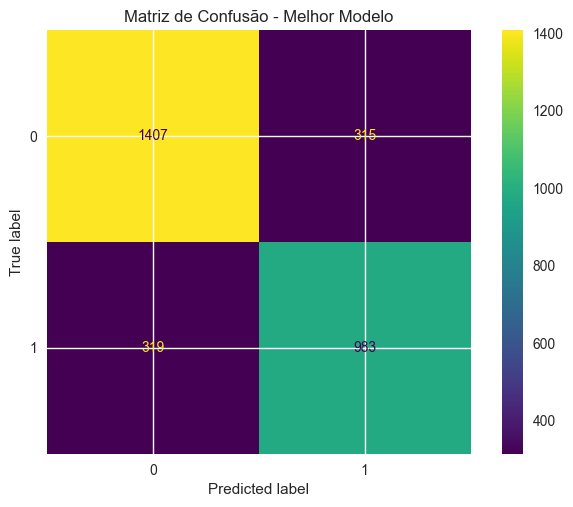

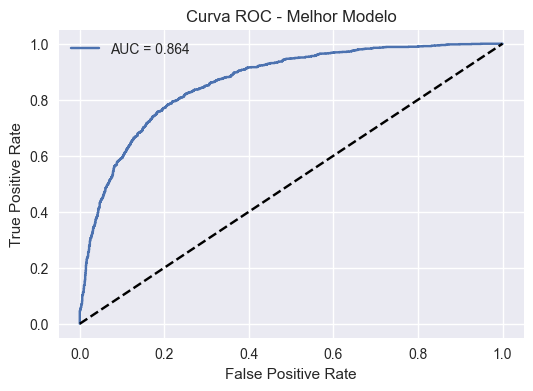

In [12]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - Melhor Modelo')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Melhor Modelo')
plt.legend()
plt.show()


## 6. Conclusões (a completar pelo grupo)

Sugestões para a secção de conclusões:

- Comparar o desempenho dos diferentes algoritmos testados (Logistic Regression, Random Forest, KNN);
- Justificar a escolha do modelo final com base nas métricas apresentadas;
- Discutir a capacidade do modelo em apoiar decisões de negócio na Fórmula 1 (ex.: previsão de pontuação, avaliação de risco/benefício de estratégias de corrida);
- Apontar limitações do trabalho:
  - não foram considerados fatores como condições meteorológicas, tipo de circuito, incidentes de corrida, etc.;
  - alterações das regras de pontos ao longo do tempo;
  - possível desbalanceamento entre classes (muitos pilotos não marcam pontos).

> **Tarefa:** escrever um parágrafo de síntese com os principais resultados e líções aprendidas.
